# Data Wrangling

In [ ]:
# Import Libraries and Load the Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
import folium
from folium.plugins import MarkerCluster
from pyproj import Proj, transform
from pyproj import Transformer
import geopandas as gpd
from prophet import Prophet

# Load the dataset
url = "https://www.dropbox.com/scl/fi/hzk6d57xgf7hd3h7f264h/opendata_wka_ib_gv_vb_sh_20240627.csv?rlkey=fiveybzw68426hkn1tishvvix&st=lcomgnh5&dl=1"
df = pd.read_csv(url, delimiter=';')

# Display the first few rows of the dataframe
display(df.head())

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,KREIS,GEMEINDE,TYP,HERSTELLER,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,LEISTUNGSBEZUG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,STATUS,BST_NR,ANL_NR,AKTENZEICHEN,DATENDATUM,DATENQUELLE
0,Kiel,Kiel,"Nordex N131 - 3,0 MW",Nordex,134,131,NaN,3000,kW Nennleist. Rotor.,571605,6013660,NaN,NaN,im Gen.Verf.,2000000317,1,G20/2016/085,27.06.2024,"LfU SH, Abtl. 7"
1,Kiel,Kiel,"Nordex N131 - 3,0 MW",Nordex,134,131,NaN,3000,kW Nennleist. Rotor.,572117,6013490,NaN,NaN,im Gen.Verf.,2000000317,2,G20/2016/086,27.06.2024,"LfU SH, Abtl. 7"
2,Kiel,Kiel,"Nordex N131 - 3,0 MW",Nordex,134,131,NaN,3000,kW Nennleist. Rotor.,572497,6013607,NaN,NaN,im Gen.Verf.,2000000317,3,G20/2016/087,27.06.2024,"LfU SH, Abtl. 7"
3,Lübeck,Lübeck,Enercon E 82 E,Enercon,78,82,"104,5 dB(A)",2300,kW Nennleist. Rotor.,619817,5978875,01.04.2011,25.09.2012,in Betrieb,3000924205,1,G30/031/2010,27.06.2024,"LfU SH, Abtl. 7"
4,Lübeck,Lübeck,Enercon E-82 E,Enercon,85,82,"104,5",2300,kW Nennleist. Rotor.,619815,5977994,01.04.2011,25.09.2012,in Betrieb,3000924205,2,G30/030/2010,27.06.2024,"LfU SH, Abtl. 7"


In [ ]:
# Translate Columns name
df.rename(columns={
    'KREIS': 'DISTRICT',
    'GEMEINDE': 'COMMUNITY',
    'TYP': 'TYPE',
    'HERSTELLER': 'MANUFACTURER',
    'NABENHOEHE': 'HUB_HEIGHT',
    'ROTORDURCHMESSER': 'ROTOR_DIAMETER',
    'SCHALLLEISTUNGSPEGEL': 'SOUND_POWER_LEVEL',
    'LEISTUNG': 'POWER',
    'LEISTUNGSBEZUG': 'POWER_REFERENCE',
    'OSTWERT': 'EASTING',
    'NORDWERT': 'NORTHING',
    'GENEHMIGT_AM': 'APPROVED_ON',
    'INBETRIEBNAHME': 'COMMISSIONED_ON',
    'STATUS': 'STATUS',
    'BST_NR': 'BST_NUMBER',
    'ANL_NR': 'PLANT_NUMBER',
    'AKTENZEICHEN': 'FILE_REFERENCE',
    'DATENDATUM': 'DATA_DATE',
    'DATENQUELLE': 'DATA_SOURCE'
}, inplace=True)

# Display the new column names
print("New column names:", df.columns)


New column names: Index(['DISTRICT', 'COMMUNITY', 'TYPE', 'MANUFACTURER', 'HUB_HEIGHT',
       'ROTOR_DIAMETER', 'SOUND_POWER_LEVEL', 'POWER', 'POWER_REFERENCE',
       'EASTING', 'NORTHING', 'APPROVED_ON', 'COMMISSIONED_ON', 'STATUS',
       'BST_NUMBER', 'PLANT_NUMBER', 'FILE_REFERENCE', 'DATA_DATE',
       'DATA_SOURCE'],
      dtype='object')


In [ ]:
# Check for duplicate rows
duplicates = df[df.duplicated()]

# Display the number of duplicates
print(f"Number of duplicate rows: {len(duplicates)}")

# Optionally, view the duplicate rows
print(duplicates)


Number of duplicate rows: 0
Empty DataFrame
Columns: [DISTRICT, COMMUNITY, TYPE, MANUFACTURER, HUB_HEIGHT, ROTOR_DIAMETER, SOUND_POWER_LEVEL, POWER, POWER_REFERENCE, EASTING, NORTHING, APPROVED_ON, COMMISSIONED_ON, STATUS, BST_NUMBER, PLANT_NUMBER, FILE_REFERENCE, DATA_DATE, DATA_SOURCE]
Index: []


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 DISTRICT               0
COMMUNITY              0
TYPE                  10
MANUFACTURER           0
HUB_HEIGHT            32
ROTOR_DIAMETER        33
SOUND_POWER_LEVEL    224
POWER                  0
POWER_REFERENCE        0
EASTING                0
NORTHING               0
APPROVED_ON          356
COMMISSIONED_ON      800
STATUS                 0
BST_NUMBER             0
PLANT_NUMBER           0
FILE_REFERENCE         8
DATA_DATE              0
DATA_SOURCE            0
dtype: int64


In [ ]:
# Convert date columns to datetime format
df['APPROVED_ON'] = pd.to_datetime(df['APPROVED_ON'], errors='coerce')
df['COMMISSIONED_ON'] = pd.to_datetime(df['COMMISSIONED_ON'], errors='coerce')
df['DATA_DATE'] = pd.to_datetime(df['DATA_DATE'], format='%d.%m.%Y', errors='coerce')

# Convert numeric columns with decimal separator as comma to float
df['HUB_HEIGHT'] = df['HUB_HEIGHT'].str.replace(',', '.').astype(float, errors='ignore')
df['ROTOR_DIAMETER'] = df['ROTOR_DIAMETER'].str.replace(',', '.').astype(float, errors='ignore')
df['SOUND_POWER_LEVEL'] = df['SOUND_POWER_LEVEL'].str.extract('(\d+,\d+)').replace(',', '.', regex=True).astype(float, errors='ignore')

# Display the data types to confirm changes
print("Data types after conversion:\n", df.dtypes)


Data types after conversion:
 DISTRICT                     object
COMMUNITY                    object
TYPE                         object
MANUFACTURER                 object
HUB_HEIGHT                  float64
ROTOR_DIAMETER              float64
SOUND_POWER_LEVEL           float64
POWER                         int64
POWER_REFERENCE              object
EASTING                       int64
NORTHING                      int64
APPROVED_ON          datetime64[ns]
COMMISSIONED_ON      datetime64[ns]
STATUS                       object
BST_NUMBER                    int64
PLANT_NUMBER                  int64
FILE_REFERENCE               object
DATA_DATE            datetime64[ns]
DATA_SOURCE                  object
dtype: object


<ipython-input-6-5d2abfd5c10f>:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['COMMISSIONED_ON'] = pd.to_datetime(df['COMMISSIONED_ON'], errors='coerce')


In [ ]:
# Drop rows where essential columns have missing values
df.dropna(subset=['HUB_HEIGHT', 'ROTOR_DIAMETER', 'APPROVED_ON'], inplace=True)

# Fill missing values for non-essential columns with a placeholder or method
df['SOUND_POWER_LEVEL'].fillna(df['SOUND_POWER_LEVEL'].mean(), inplace=True)

# Verify no essential missing values remain
print("Missing values after handling:\n", df.isnull().sum())


Missing values after handling:
 DISTRICT               0
COMMUNITY              0
TYPE                   3
MANUFACTURER           0
HUB_HEIGHT             0
ROTOR_DIAMETER         0
SOUND_POWER_LEVEL      0
POWER                  0
POWER_REFERENCE        0
EASTING                0
NORTHING               0
APPROVED_ON            0
COMMISSIONED_ON      129
STATUS                 0
BST_NUMBER             0
PLANT_NUMBER           0
FILE_REFERENCE         0
DATA_DATE              0
DATA_SOURCE            0
dtype: int64


In [ ]:
# Feature engineering: Calculate the age of the wind turbine since commissioning
df['AGE'] = (pd.to_datetime('today') - df['COMMISSIONED_ON']).dt.days / 365.25

# Filter data for turbines that are in operation
df_in_operation = df[df['STATUS'] == 'in Betrieb']

# Display the first few rows of the transformed dataframe
display(df_in_operation.head())


,DISTRICT,COMMUNITY,TYPE,MANUFACTURER,HUB_HEIGHT,ROTOR_DIAMETER,SOUND_POWER_LEVEL,POWER,POWER_REFERENCE,EASTING,NORTHING,APPROVED_ON,COMMISSIONED_ON,STATUS,BST_NUMBER,PLANT_NUMBER,FILE_REFERENCE,DATA_DATE,DATA_SOURCE,AGE
3,Lübeck,Lübeck,Enercon E 82 E,Enercon,78.0,82.0,104.5,2300,kW Nennleist. Rotor.,619817,5978875,2011-01-04,2012-09-25,in Betrieb,3000924205,1,G30/031/2010,2024-06-27,"LfU SH, Abtl. 7",11.874059
4,Lübeck,Lübeck,Enercon E-82 E,Enercon,85.0,82.0,104.5,2300,kW Nennleist. Rotor.,619815,5977994,2011-01-04,2012-09-25,in Betrieb,3000924205,2,G30/030/2010,2024-06-27,"LfU SH, Abtl. 7",11.874059
7,Dithmarschen,Albersdorf,Vestas V112,Vestas,119.0,112.0,106.5,3450,kW Nennleist. Rotor.,516648,5999295,2013-07-10,2014-06-11,in Betrieb,51001900011,1,G10/2013/012,2024-06-27,"LfU SH, Abtl. 7",10.165640
8,Dithmarschen,Albersdorf,Vestas V112,Vestas,119.0,112.0,106.5,3450,kW Nennleist. Rotor.,516599,5998975,2013-07-10,2014-06-11,in Betrieb,51001900011,2,G10/2013/013,2024-06-27,"LfU SH, Abtl. 7",10.165640
9,Dithmarschen,Albersdorf,Vestas V112 3.3,Vestas,119.0,112.0,106.5,3450,kW Nennleist. Rotor.,516709,5998672,2013-07-10,2014-06-11,in Betrieb,51001900011,3,G10/2013/014,2024-06-27,"LfU SH, Abtl. 7",10.165640


# Exploratory Data Analysis (EDA)

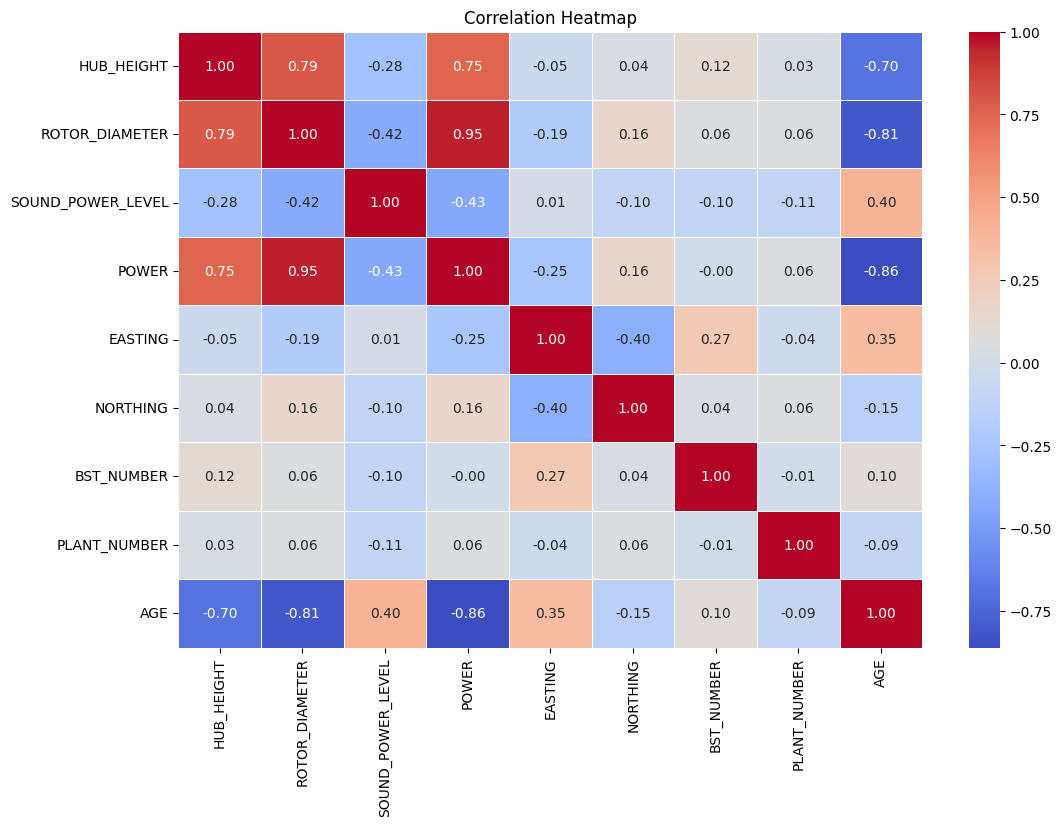

,EASTING,NORTHING,LATITUDE,LONGITUDE
3,619817,5978875,53.944364,10.825546
4,619815,5977994,53.936450,10.825170
7,516648,5999295,54.141498,9.254841
8,516599,5998975,54.138624,9.254073
9,516709,5998672,54.135897,9.255740
...,...,...,...,...
3955,591704,5955338,53.738618,10.390349
3956,594204,5952784,53.715223,10.427462
3957,594429,5952880,53.716045,10.430899
3958,594732,5952789,53.715172,10.435461


In [ ]:
# Define a function to detect and handle outliers using the IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter out outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return df_filtered

# Handle outliers for 'HUB_HEIGHT' and 'ROTOR_DIAMETER'
df = handle_outliers(df, 'HUB_HEIGHT')
df = handle_outliers(df, 'ROTOR_DIAMETER')
df = handle_outliers(df, 'AGE')

# handle outliers for 'POWER'
df = handle_outliers(df, 'POWER')

# Ensure 'EASTING' and 'NORTHING' are numeric (in case they're not)
df.loc[:, 'EASTING'] = pd.to_numeric(df['EASTING'], errors='coerce')
df.loc[:, 'NORTHING'] = pd.to_numeric(df['NORTHING'], errors='coerce')


# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Define the transformer (Assuming UTM Zone 32N to WGS84)
transformer = Transformer.from_crs(
    crs_from='epsg:32632',  # UTM Zone 32N, WGS84
    crs_to='epsg:4326',     # WGS84
    always_xy=True
)


# Convert Easting and Northing to Longitude and Latitude
df['LONGITUDE'], df['LATITUDE'] = transformer.transform(df['EASTING'].values, df['NORTHING'].values)

# Display the first few rows to check the conversion
df[['EASTING', 'NORTHING', 'LATITUDE', 'LONGITUDE']]


## Visualization with regression line

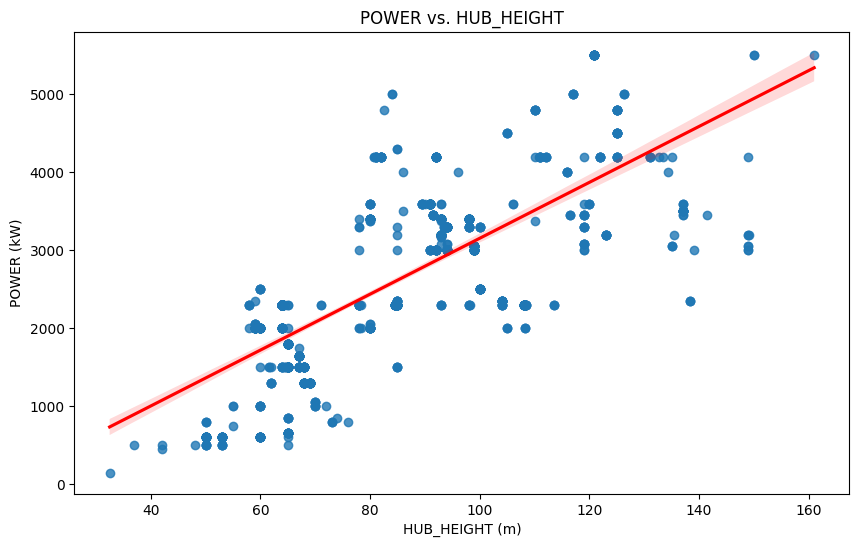

In [ ]:
#Visualization with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='HUB_HEIGHT', y='POWER', line_kws={'color': 'red'})
plt.title('POWER vs. HUB_HEIGHT')
plt.xlabel('HUB_HEIGHT (m)')
plt.ylabel('POWER (kW)')
plt.show()

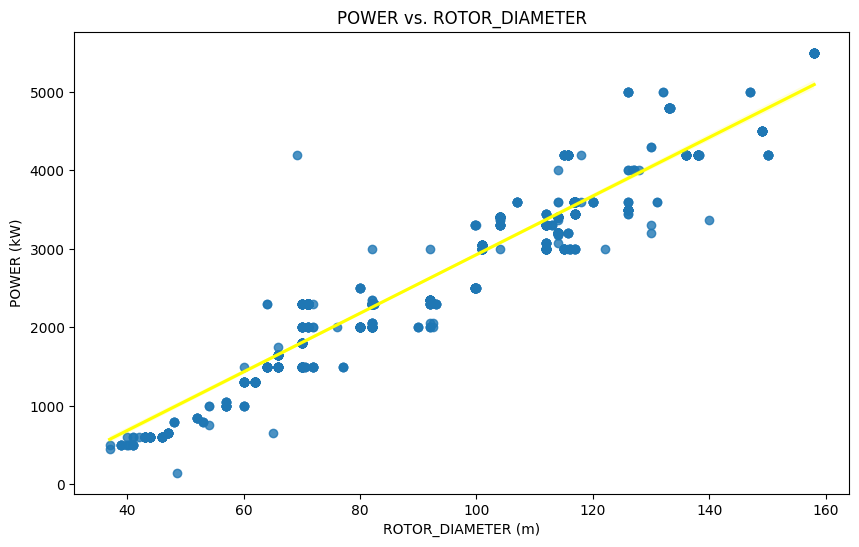

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='ROTOR_DIAMETER', y='POWER', line_kws={'color': 'yellow'})
plt.title('POWER vs. ROTOR_DIAMETER')
plt.xlabel('ROTOR_DIAMETER (m)')
plt.ylabel('POWER (kW)')
plt.show()

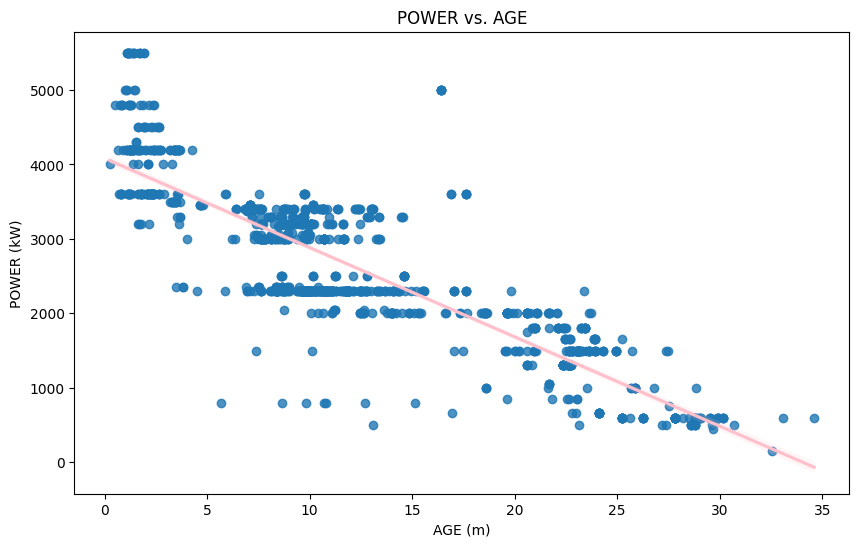

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='AGE', y='POWER', line_kws={'color': 'pink'})
plt.title('POWER vs. AGE')
plt.xlabel('AGE (m)')
plt.ylabel('POWER (kW)')
plt.show()

## Data distribution

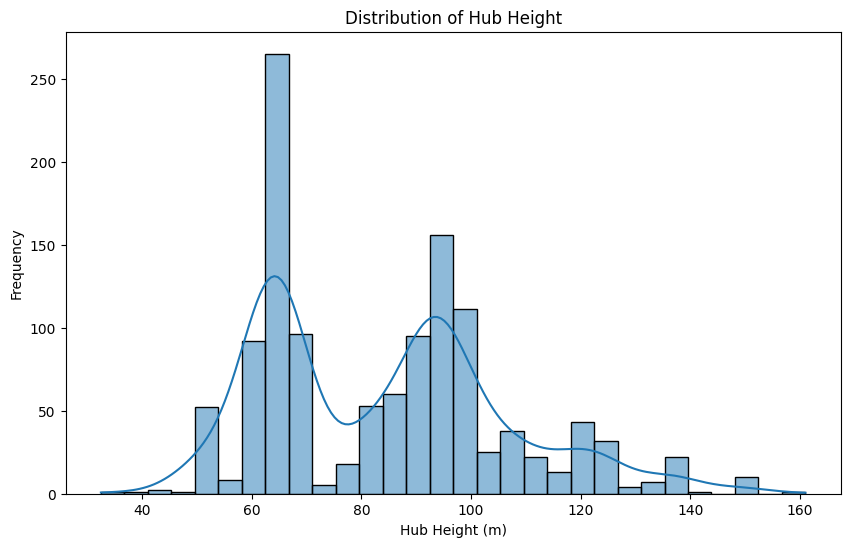

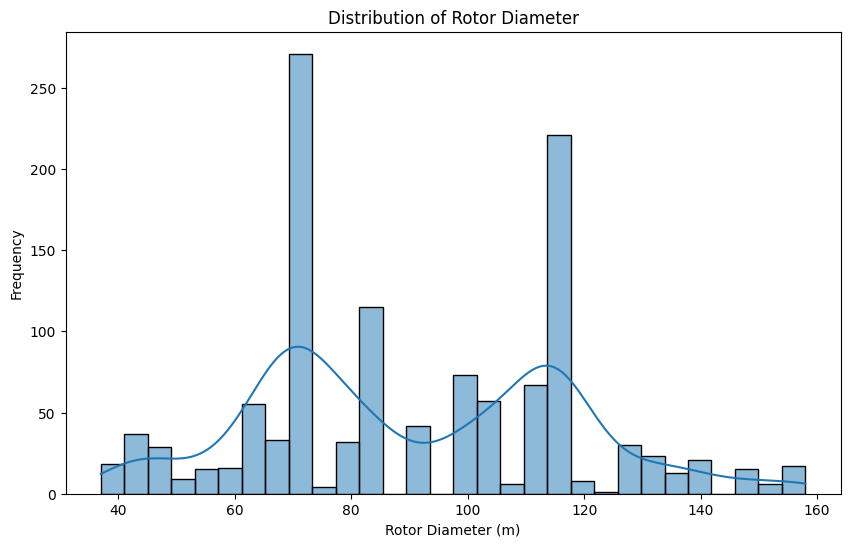

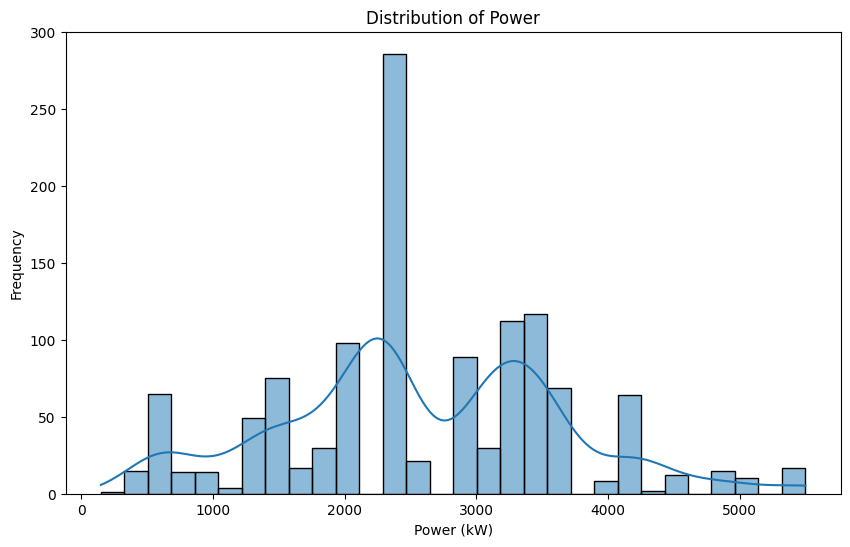

In [ ]:
# Plotting the distribution of HUB_HEIGHT
plt.figure(figsize=(10, 6))
sns.histplot(df['HUB_HEIGHT'], bins=30, kde=True)
plt.title('Distribution of Hub Height')
plt.xlabel('Hub Height (m)')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of ROTOR_DIAMETER
plt.figure(figsize=(10, 6))
sns.histplot(df['ROTOR_DIAMETER'], bins=30, kde=True)
plt.title('Distribution of Rotor Diameter')
plt.xlabel('Rotor Diameter (m)')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of POWER
plt.figure(figsize=(10, 6))
sns.histplot(df['POWER'], bins=30, kde=True)
plt.title('Distribution of Power')
plt.xlabel('Power (kW)')
plt.ylabel('Frequency')
plt.show()



### Square Root Transformation

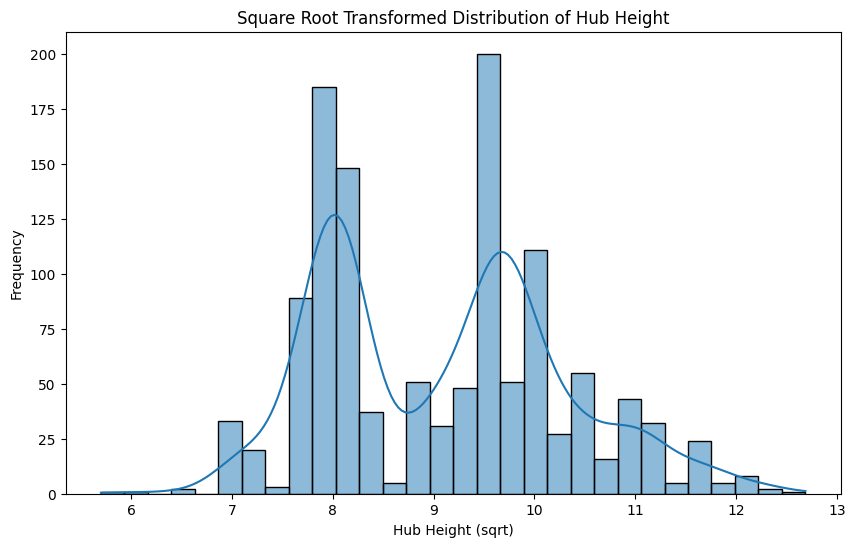

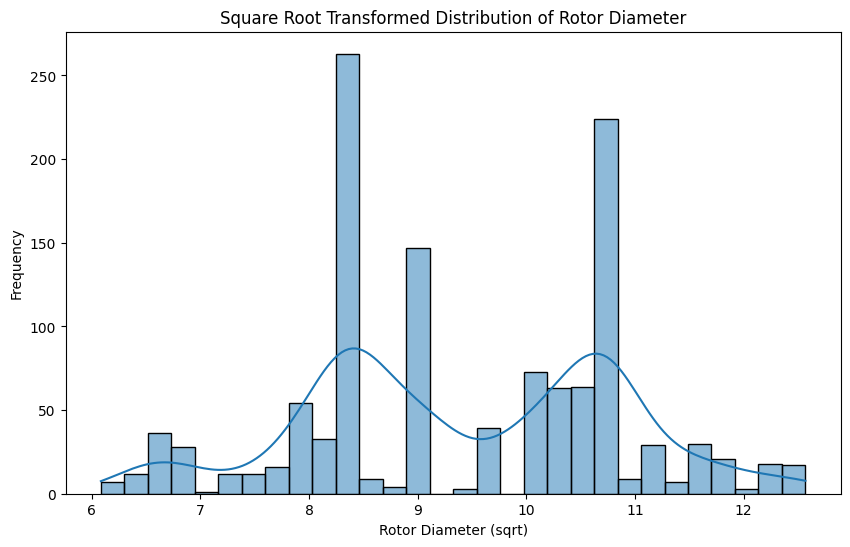

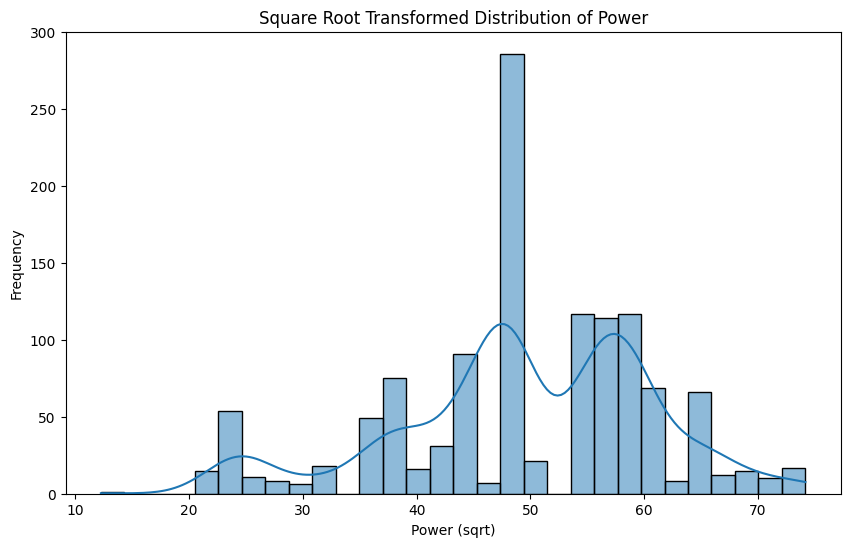

In [ ]:
# Apply square root transformation
df['HUB_HEIGHT_sqrt'] = np.sqrt(df['HUB_HEIGHT'])
df['ROTOR_DIAMETER_sqrt'] = np.sqrt(df['ROTOR_DIAMETER'])
df['POWER_sqrt'] = np.sqrt(df['POWER'])

# Plotting the transformed distributions
plt.figure(figsize=(10, 6))
sns.histplot(df['HUB_HEIGHT_sqrt'], bins=30, kde=True)
plt.title('Square Root Transformed Distribution of Hub Height')
plt.xlabel('Hub Height (sqrt)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['ROTOR_DIAMETER_sqrt'], bins=30, kde=True)
plt.title('Square Root Transformed Distribution of Rotor Diameter')
plt.xlabel('Rotor Diameter (sqrt)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['POWER_sqrt'], bins=30, kde=True)
plt.title('Square Root Transformed Distribution of Power')
plt.xlabel('Power (sqrt)')
plt.ylabel('Frequency')
plt.show()


### Log Transformation

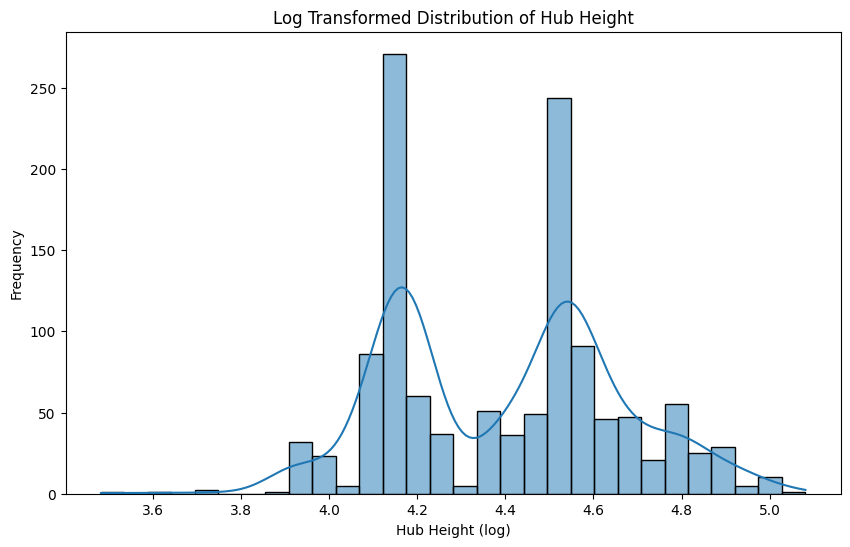

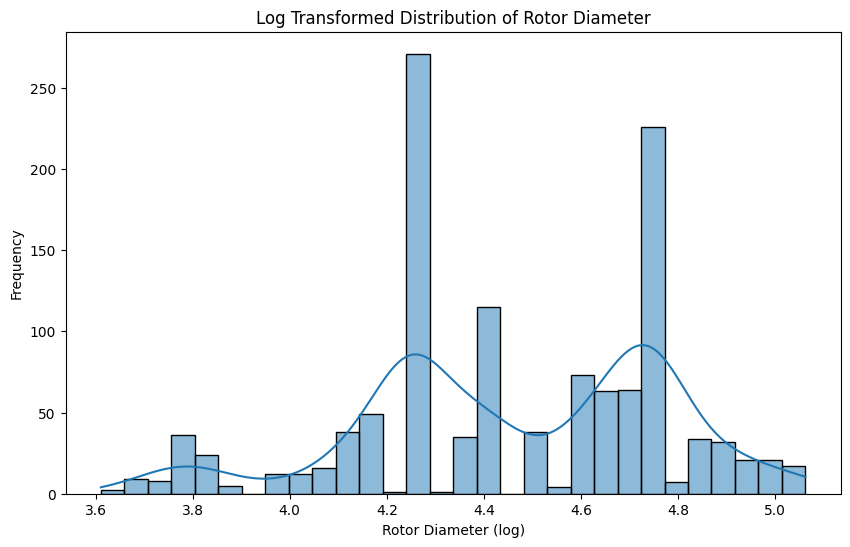

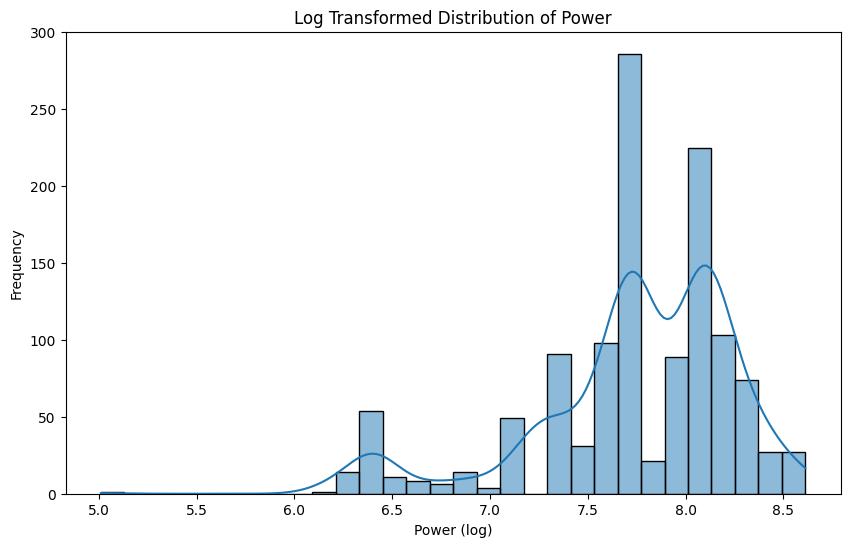

In [ ]:
# Apply log transformation
df['HUB_HEIGHT_log'] = np.log(df['HUB_HEIGHT'])
df['ROTOR_DIAMETER_log'] = np.log(df['ROTOR_DIAMETER'])
df['POWER_log'] = np.log(df['POWER'])

# Plotting the transformed distributions
plt.figure(figsize=(10, 6))
sns.histplot(df['HUB_HEIGHT_log'], bins=30, kde=True)
plt.title('Log Transformed Distribution of Hub Height')
plt.xlabel('Hub Height (log)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['ROTOR_DIAMETER_log'], bins=30, kde=True)
plt.title('Log Transformed Distribution of Rotor Diameter')
plt.xlabel('Rotor Diameter (log)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['POWER_log'], bins=30, kde=True)
plt.title('Log Transformed Distribution of Power')
plt.xlabel('Power (log)')
plt.ylabel('Frequency')
plt.show()


### Box-Cox Transformation

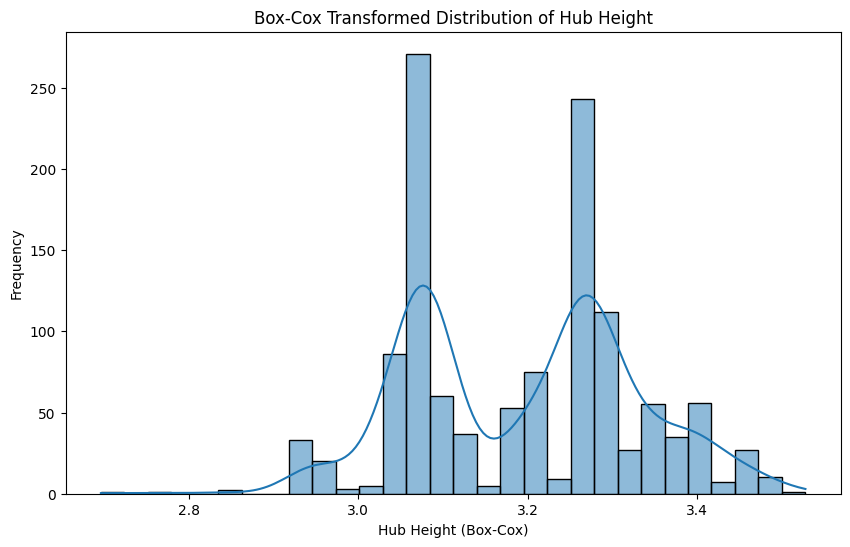

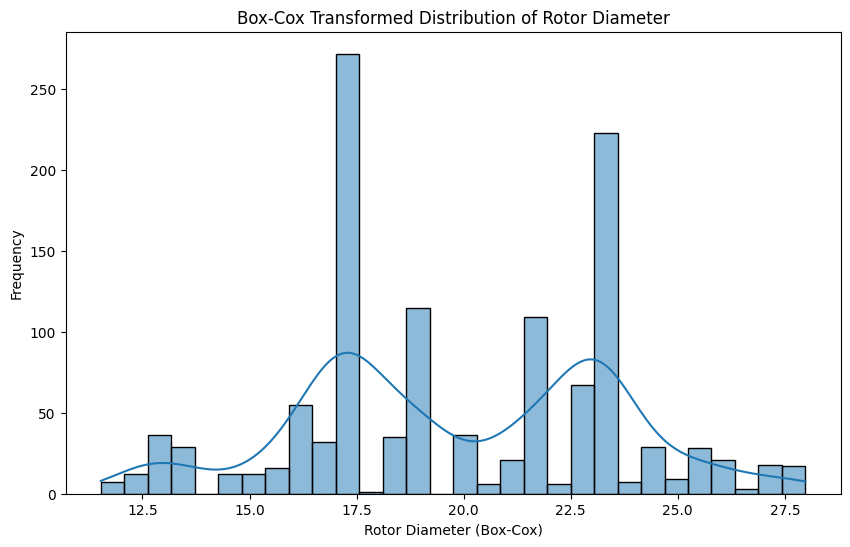

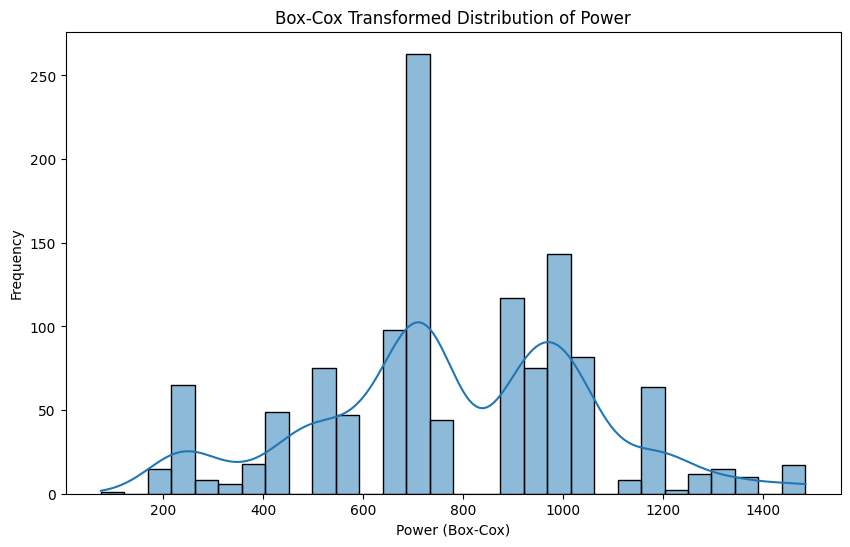

In [ ]:
# Apply Box-Cox transformation
df['HUB_HEIGHT_boxcox'], _ = stats.boxcox(df['HUB_HEIGHT'])
df['ROTOR_DIAMETER_boxcox'], _ = stats.boxcox(df['ROTOR_DIAMETER'])
df['POWER_boxcox'], _ = stats.boxcox(df['POWER'])

# Plotting the transformed distributions
plt.figure(figsize=(10, 6))
sns.histplot(df['HUB_HEIGHT_boxcox'], bins=30, kde=True)
plt.title('Box-Cox Transformed Distribution of Hub Height')
plt.xlabel('Hub Height (Box-Cox)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['ROTOR_DIAMETER_boxcox'], bins=30, kde=True)
plt.title('Box-Cox Transformed Distribution of Rotor Diameter')
plt.xlabel('Rotor Diameter (Box-Cox)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['POWER_boxcox'], bins=30, kde=True)
plt.title('Box-Cox Transformed Distribution of Power')
plt.xlabel('Power (Box-Cox)')
plt.ylabel('Frequency')
plt.show()


# Comparison Across Manufacturers:

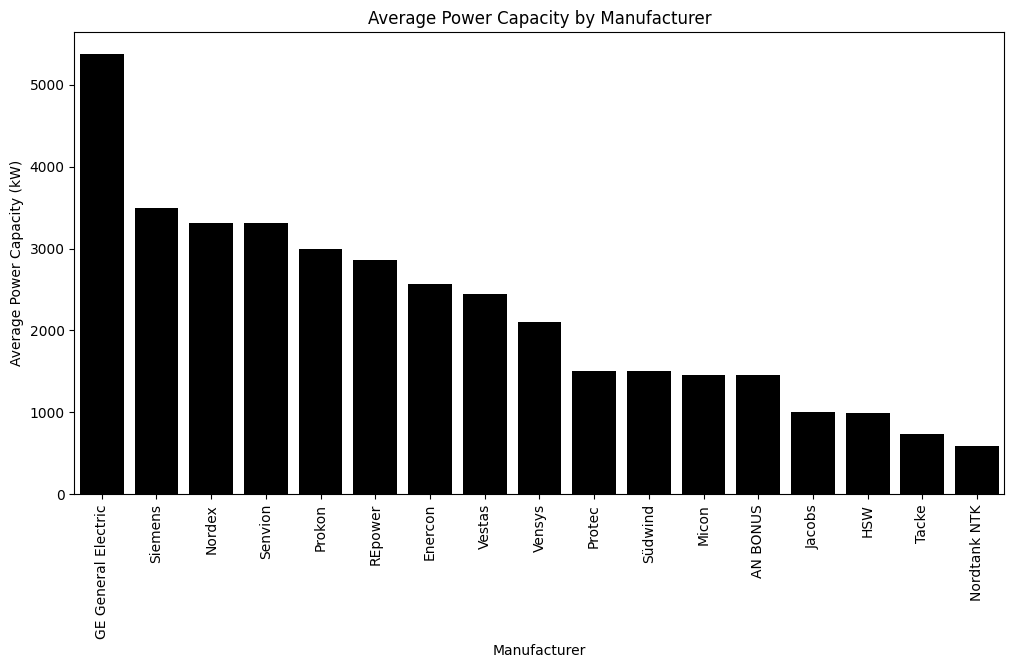

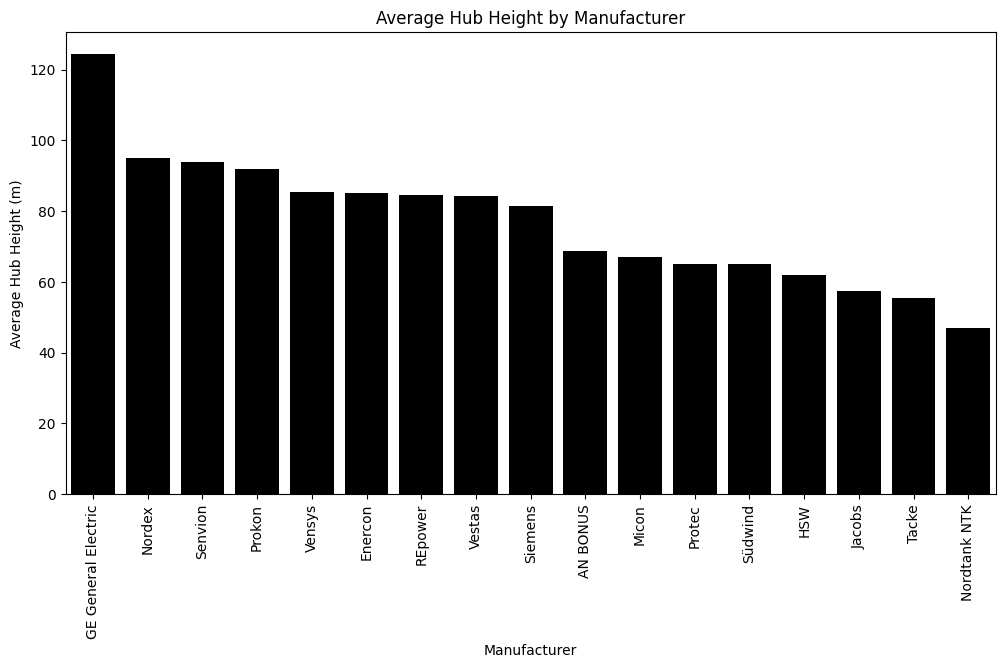

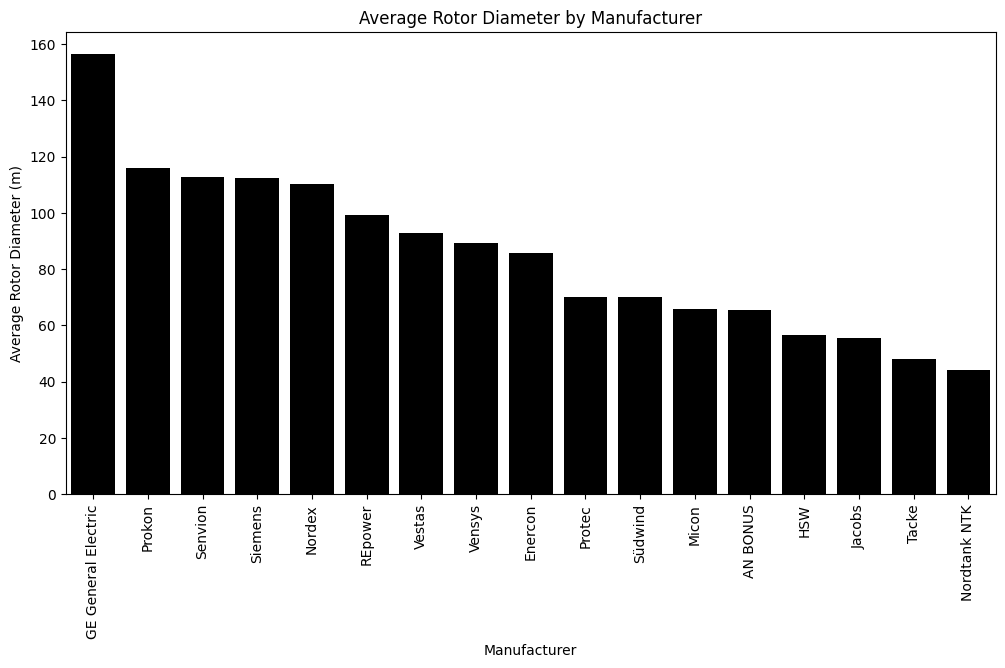

In [ ]:
# Group by manufacturer and calculate average values
manufacturer_stats = df.groupby('MANUFACTURER').agg({
    'POWER': 'mean',
    'HUB_HEIGHT': 'mean',
    'ROTOR_DIAMETER': 'mean'
}).reset_index()

# Sort by POWER in descending order
manufacturer_stats_sorted_power = manufacturer_stats.sort_values(by='POWER', ascending=False)

# Sort by HUB_HEIGHT in descending order
manufacturer_stats_sorted_hub_height = manufacturer_stats.sort_values(by='HUB_HEIGHT', ascending=False)

# Sort by ROTOR_DIAMETER in descending order
manufacturer_stats_sorted_rotor_diameter = manufacturer_stats.sort_values(by='ROTOR_DIAMETER', ascending=False)

# Plot average power capacity by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='POWER', data=manufacturer_stats_sorted_power, color='black')
plt.xticks(rotation=90)
plt.title('Average Power Capacity by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Power Capacity (kW)')
plt.show()

# Plot average hub height by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='HUB_HEIGHT', data=manufacturer_stats_sorted_hub_height, color='black')
plt.xticks(rotation=90)
plt.title('Average Hub Height by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Hub Height (m)')
plt.show()

# Plot average rotor diameter by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='ROTOR_DIAMETER', data=manufacturer_stats_sorted_rotor_diameter, color='black')
plt.xticks(rotation=90)
plt.title('Average Rotor Diameter by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Rotor Diameter (m)')
plt.show()


## Impact of Number of Turbines on Average Power Capacity
Count the Number of Turbines per Manufacturer

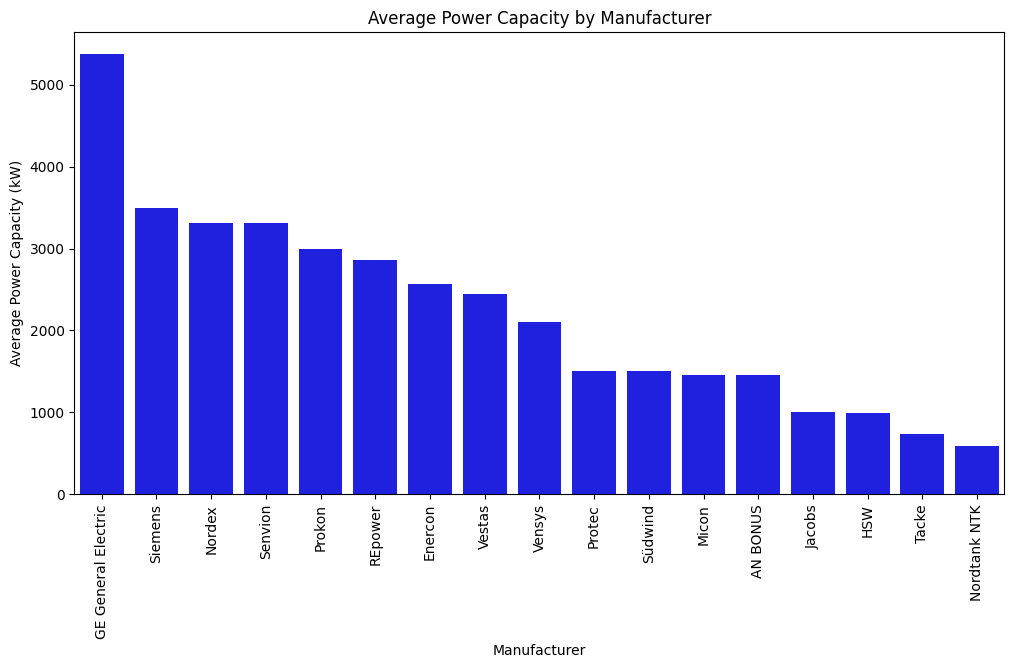

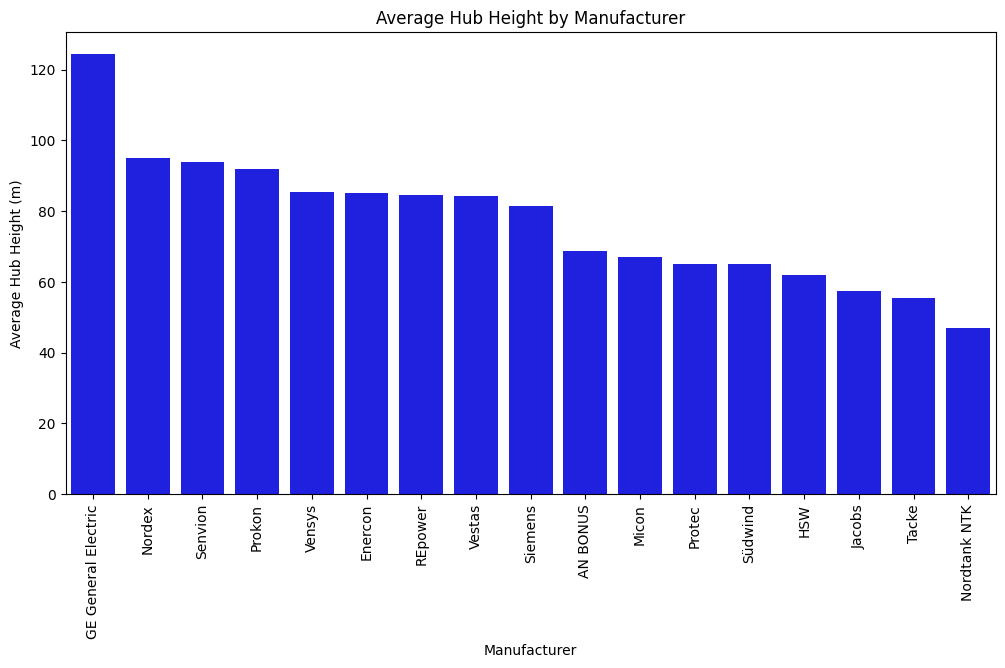

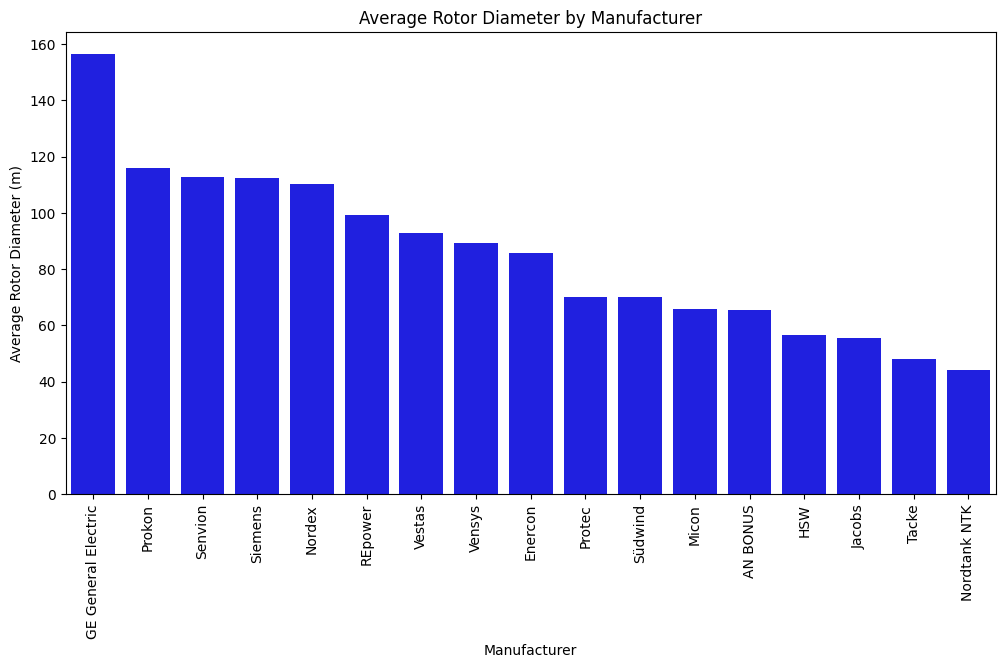

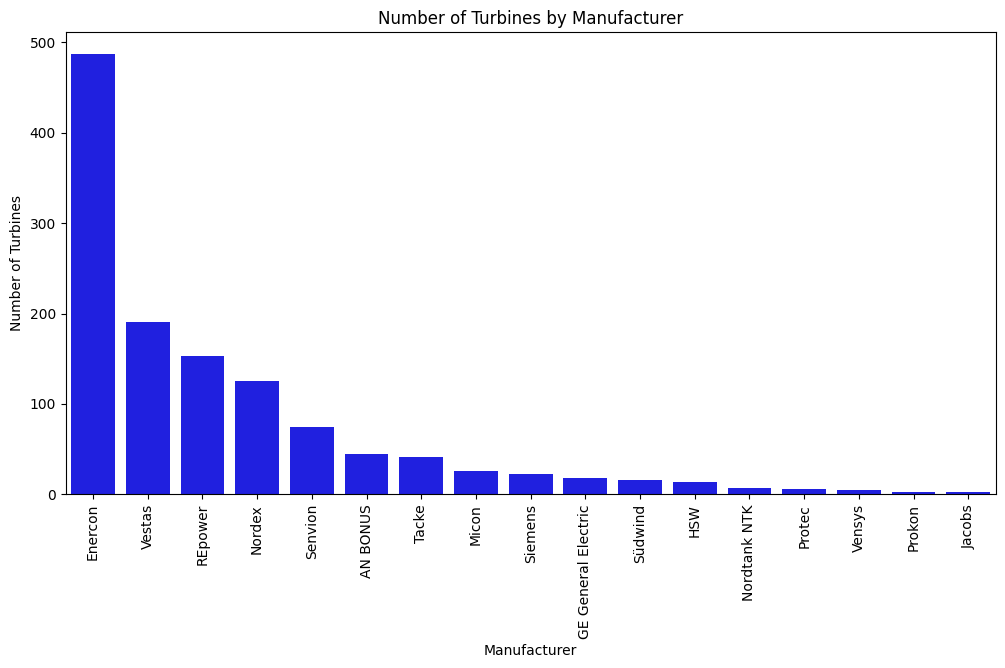

           MANUFACTURER  Number of Turbines
0              AN BONUS                  45
1               Enercon                 487
2   GE General Electric                  18
3                   HSW                  13
4                Jacobs                   2
5                 Micon                  26
6                Nordex                 125
7          Nordtank NTK                   7
8                Prokon                   3
9                Protec                   6
10              REpower                 153
11              Senvion                  74
12              Siemens                  22
13              Südwind                  16
14                Tacke                  41
15               Vensys                   5
16               Vestas                 191


In [ ]:
# Group by manufacturer and calculate mean values
manufacturer_stats = df.groupby('MANUFACTURER').agg({
    'POWER': 'mean',
    'HUB_HEIGHT': 'mean',
    'ROTOR_DIAMETER': 'mean'
}).reset_index()

# Count the number of turbines each manufacturer has
turbine_counts = df.groupby('MANUFACTURER').size().reset_index(name='Number of Turbines')

# Merge turbine counts with manufacturer stats
manufacturer_stats = manufacturer_stats.merge(turbine_counts, on='MANUFACTURER')

# Sort by POWER in descending order
manufacturer_stats_sorted_power = manufacturer_stats.sort_values(by='POWER', ascending=False)

# Sort by HUB_HEIGHT in descending order
manufacturer_stats_sorted_hub_height = manufacturer_stats.sort_values(by='HUB_HEIGHT', ascending=False)

# Sort by ROTOR_DIAMETER in descending order
manufacturer_stats_sorted_rotor_diameter = manufacturer_stats.sort_values(by='ROTOR_DIAMETER', ascending=False)

# Sort by Number of Turbines in descending order
manufacturer_stats_sorted_turbines = manufacturer_stats.sort_values(by='Number of Turbines', ascending=False)

# Plot average power capacity by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='POWER', data=manufacturer_stats_sorted_power, color='blue')
plt.xticks(rotation=90)
plt.title('Average Power Capacity by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Power Capacity (kW)')
plt.show()

# Plot average hub height by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='HUB_HEIGHT', data=manufacturer_stats_sorted_hub_height, color='blue')
plt.xticks(rotation=90)
plt.title('Average Hub Height by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Hub Height (m)')
plt.show()

# Plot average rotor diameter by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='ROTOR_DIAMETER', data=manufacturer_stats_sorted_rotor_diameter, color='blue')
plt.xticks(rotation=90)
plt.title('Average Rotor Diameter by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Rotor Diameter (m)')
plt.show()

# Plot number of turbines by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='Number of Turbines', data=manufacturer_stats_sorted_turbines, color='blue')
plt.xticks(rotation=90)
plt.title('Number of Turbines by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Turbines')
plt.show()

# Display turbine counts
print(turbine_counts)



## Ensure that the manufacturer analysis is robust and fair.

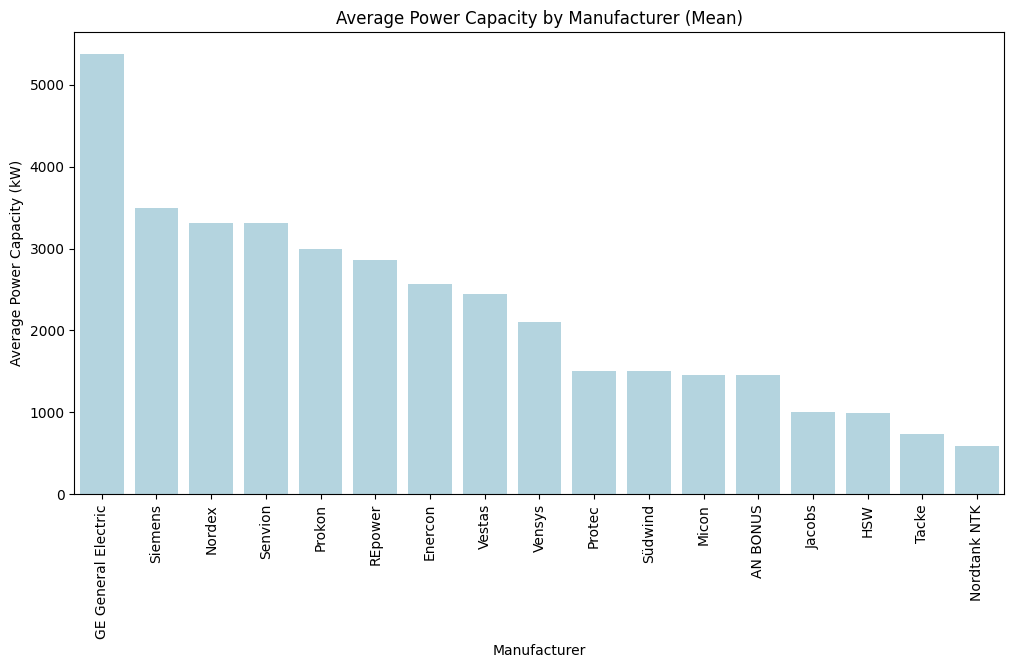

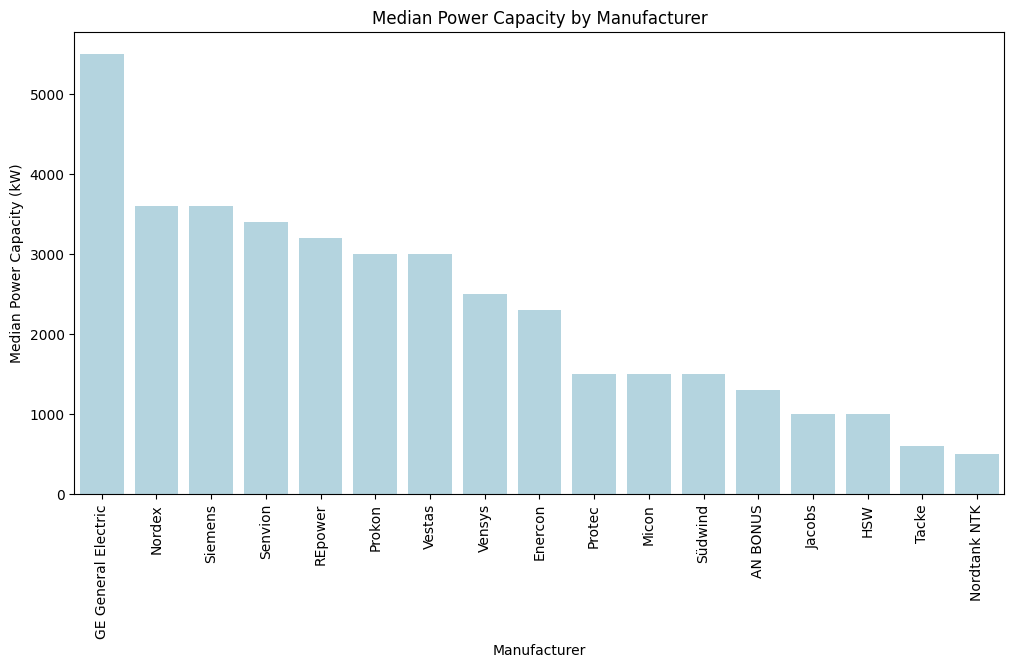

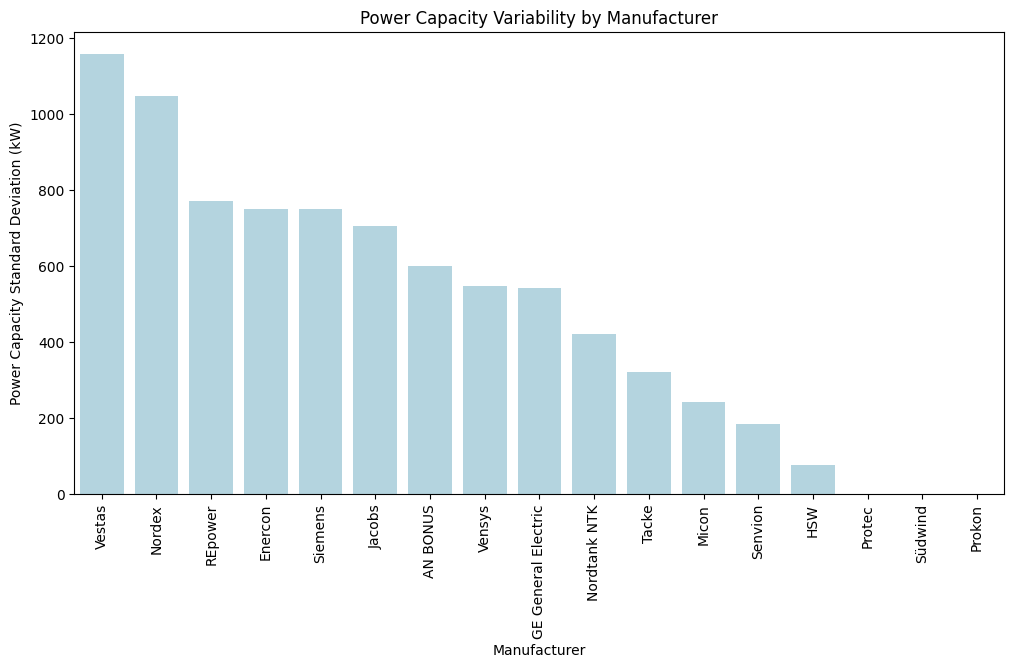

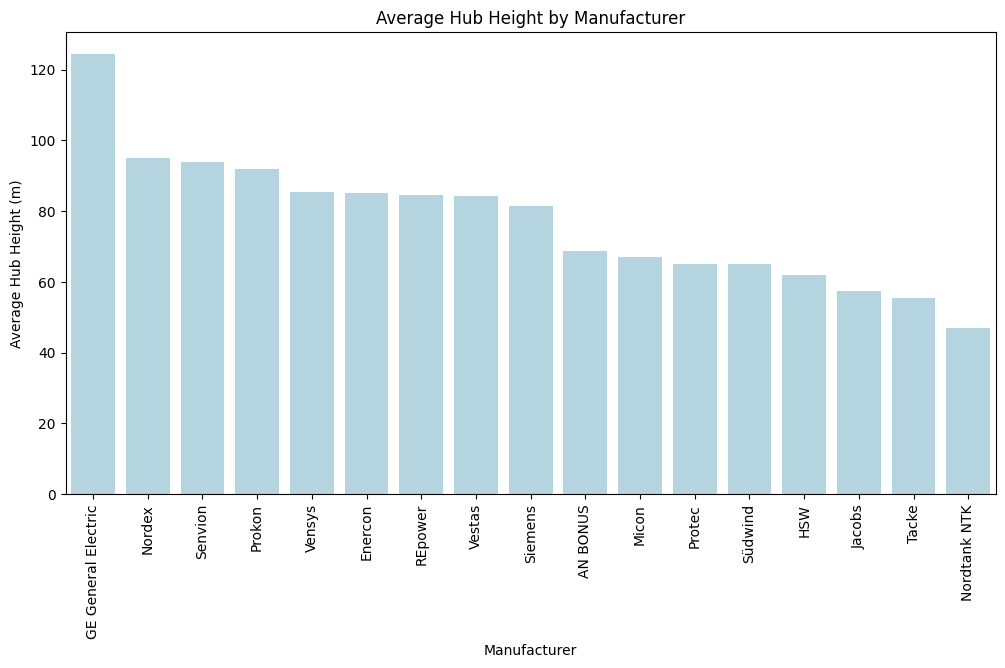

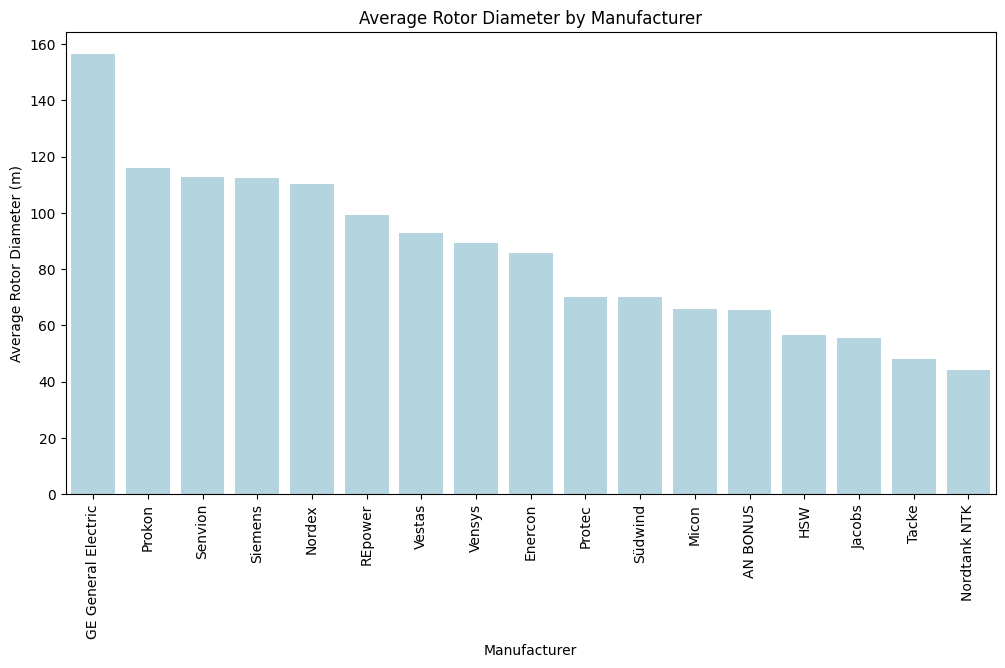

In [ ]:

# Group by manufacturer and calculate mean, median, and standard deviation
manufacturer_stats = df.groupby('MANUFACTURER').agg({
    'POWER': ['mean', 'median', 'std'],
    'HUB_HEIGHT': 'mean',
    'ROTOR_DIAMETER': 'mean',
    'MANUFACTURER': 'size'
}).reset_index()

# Rename columns for clarity
manufacturer_stats.columns = ['MANUFACTURER', 'Mean Power', 'Median Power', 'Power Std Dev', 'Average Hub Height', 'Average Rotor Diameter', 'Number of Turbines']

# Sort by Mean Power in descending order
manufacturer_stats_sorted_mean_power = manufacturer_stats.sort_values(by='Mean Power', ascending=False)

# Plot average power capacity by manufacturer (sorted by Mean Power)
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='Mean Power', data=manufacturer_stats_sorted_mean_power, color='lightblue')
plt.xticks(rotation=90)
plt.title('Average Power Capacity by Manufacturer (Mean)')
plt.xlabel('Manufacturer')
plt.ylabel('Average Power Capacity (kW)')
plt.show()

# Sort by Median Power in descending order
manufacturer_stats_sorted_median_power = manufacturer_stats.sort_values(by='Median Power', ascending=False)

# Plot median power capacity by manufacturer (sorted by Median Power)
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='Median Power', data=manufacturer_stats_sorted_median_power, color='lightblue')
plt.xticks(rotation=90)
plt.title('Median Power Capacity by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Median Power Capacity (kW)')
plt.show()

# Sort by Power Std Dev in descending order
manufacturer_stats_sorted_power_std_dev = manufacturer_stats.sort_values(by='Power Std Dev', ascending=False)

# Plot power capacity standard deviation by manufacturer (sorted by Power Std Dev)
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='Power Std Dev', data=manufacturer_stats_sorted_power_std_dev, color='lightblue')
plt.xticks(rotation=90)
plt.title('Power Capacity Variability by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Power Capacity Standard Deviation (kW)')
plt.show()

# Sort by Average Hub Height in descending order
manufacturer_stats_sorted_hub_height = manufacturer_stats.sort_values(by='Average Hub Height', ascending=False)

# Plot average hub height by manufacturer (sorted by Average Hub Height)
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='Average Hub Height', data=manufacturer_stats_sorted_hub_height, color='lightblue')
plt.xticks(rotation=90)
plt.title('Average Hub Height by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Hub Height (m)')
plt.show()

# Sort by Average Rotor Diameter in descending order
manufacturer_stats_sorted_rotor_diameter = manufacturer_stats.sort_values(by='Average Rotor Diameter', ascending=False)

# Plot average rotor diameter by manufacturer (sorted by Average Rotor Diameter)
plt.figure(figsize=(12, 6))
sns.barplot(x='MANUFACTURER', y='Average Rotor Diameter', data=manufacturer_stats_sorted_rotor_diameter, color='lightblue')
plt.xticks(rotation=90)
plt.title('Average Rotor Diameter by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Rotor Diameter (m)')
plt.show()


# Geographical Distribution:




<ipython-input-20-f0ed58c80565>:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['LATITUDE'], df['LONGITUDE'] = transform(utm_proj, wgs_proj, df['EASTING'].values, df['NORTHING'].values)


,EASTING,NORTHING,LATITUDE,LONGITUDE
3,619817,5978875,10.825546,53.944364
4,619815,5977994,10.825170,53.936450
7,516648,5999295,9.254841,54.141498
8,516599,5998975,9.254073,54.138624
9,516709,5998672,9.255740,54.135897


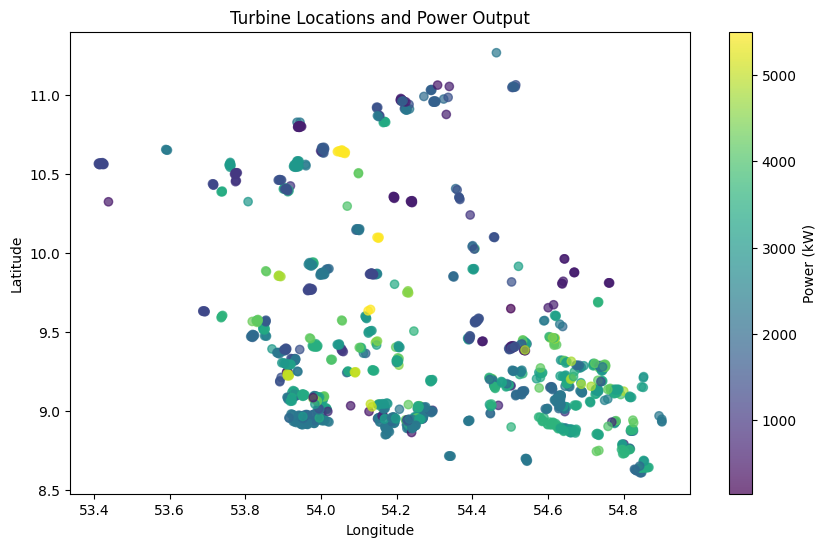

In [ ]:

# Define the projection (Assuming UTM Zone 32N)
utm_proj = Proj(proj='utm', zone=32, ellps='WGS84')
wgs_proj = Proj(proj='latlong', datum='WGS84')

# Convert Easting and Northing to Longitude and Latitude
df['LATITUDE'], df['LONGITUDE'] = transform(utm_proj, wgs_proj, df['EASTING'].values, df['NORTHING'].values)

# Display the first few rows to check the conversion
display(df[['EASTING', 'NORTHING', 'LATITUDE', 'LONGITUDE']].head())

plt.figure(figsize=(10, 6))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['POWER'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Power (kW)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Locations and Power Output')
plt.show()


Mean Squared Error: 337317.2955870445
R² Score: 0.6204501942973977


<ipython-input-21-b8df62e718c6>:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Predicted Power (kW)')


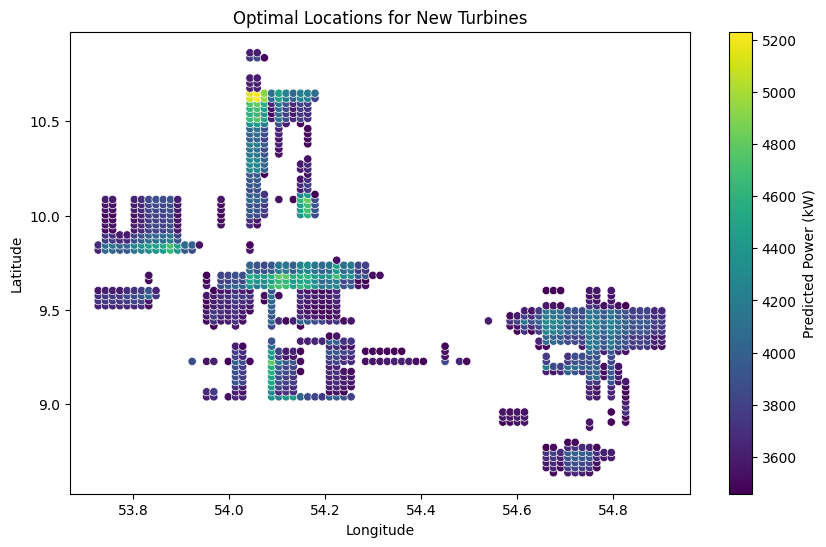

Optimal latitude range: 8.637137742341814 to 10.862492872867659
Optimal longitude range: 53.727215479978625 to 54.90138625706004
We predict that the future turbines' best regions are to the south-west.


In [ ]:
# Define features and target variable
X = df[['LATITUDE', 'LONGITUDE']]
y = df['POWER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Generate new locations to predict power output
lat_range = np.linspace(df['LATITUDE'].min(), df['LATITUDE'].max(), 100)
lon_range = np.linspace(df['LONGITUDE'].min(), df['LONGITUDE'].max(), 100)
lat_lon_grid = np.array(np.meshgrid(lat_range, lon_range)).T.reshape(-1, 2)

# Create a DataFrame for predictions
grid_df = pd.DataFrame(lat_lon_grid, columns=['LATITUDE', 'LONGITUDE'])

# Standardize the new locations
grid_df_scaled = scaler.transform(grid_df)

# Predict power output for the new locations
grid_df['PREDICTED_POWER'] = model.predict(grid_df_scaled)

# Identify optimal locations (top 10% predicted power output)
threshold = grid_df['PREDICTED_POWER'].quantile(0.90)
optimal_locations = grid_df[grid_df['PREDICTED_POWER'] >= threshold]

# Plot optimal locations
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='PREDICTED_POWER', data=optimal_locations, palette='viridis', legend=False)

# Create a colorbar
norm = plt.Normalize(vmin=optimal_locations['PREDICTED_POWER'].min(), vmax=optimal_locations['PREDICTED_POWER'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for older versions of matplotlib
plt.colorbar(sm, label='Predicted Power (kW)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Optimal Locations for New Turbines')
plt.show()

# Extracting specific recommendations
optimal_lat_min = optimal_locations['LATITUDE'].min()
optimal_lat_max = optimal_locations['LATITUDE'].max()
optimal_lon_min = optimal_locations['LONGITUDE'].min()
optimal_lon_max = optimal_locations['LONGITUDE'].max()

print(f"Optimal latitude range: {optimal_lat_min} to {optimal_lat_max}")
print(f"Optimal longitude range: {optimal_lon_min} to {optimal_lon_max}")

# Directional recommendations
if (optimal_lat_min < df['LATITUDE'].mean()) and (optimal_lon_min < df['LONGITUDE'].mean()):
    direction = "south-west"
elif (optimal_lat_min < df['LATITUDE'].mean()) and (optimal_lon_max > df['LONGITUDE'].mean()):
    direction = "south-east"
elif (optimal_lat_max > df['LATITUDE'].mean()) and (optimal_lon_min < df['LONGITUDE'].mean()):
    direction = "north-west"
else:
    direction = "north-east"

print(f"We predict that the future turbines' best regions are to the {direction}.")


#    Time Trend Analysis:

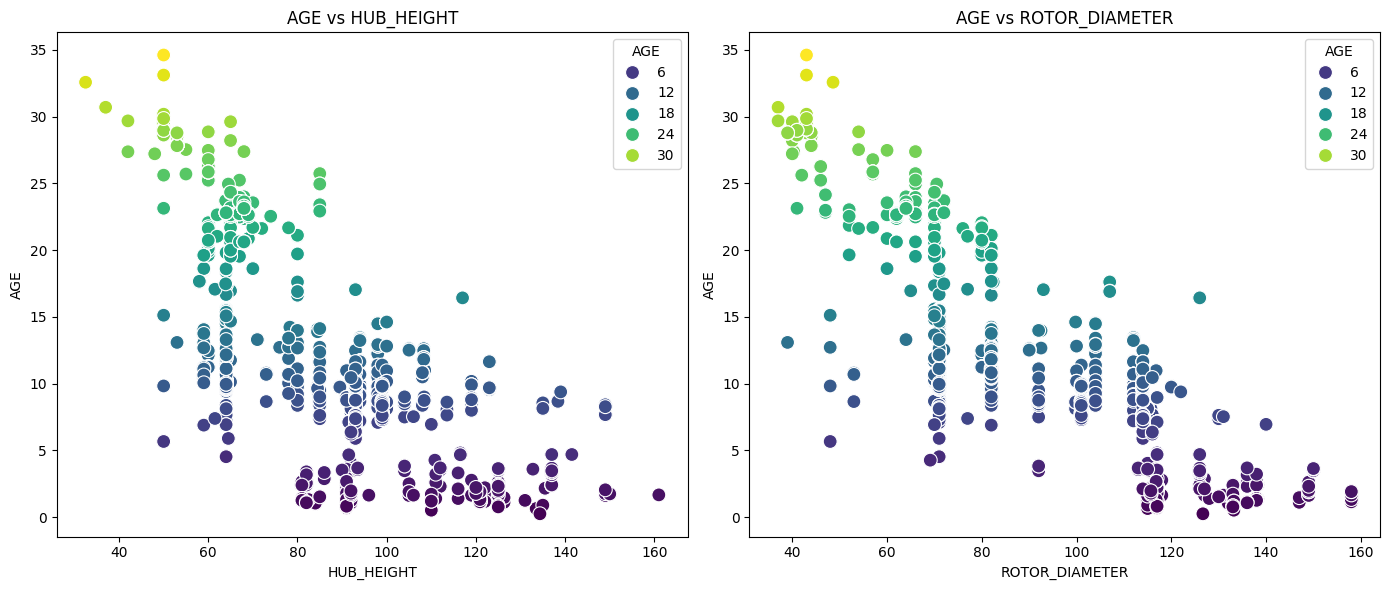

In [ ]:
# Create a figure with 2 subplots
plt.figure(figsize=(14, 6))

# Scatter plot for AGE vs HUB_HEIGHT
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='HUB_HEIGHT', y='AGE', hue='AGE', palette='viridis', s=100)
plt.title('AGE vs HUB_HEIGHT')
plt.xlabel('HUB_HEIGHT')
plt.ylabel('AGE')

# Scatter plot for AGE vs ROTOR_DIAMETER
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='ROTOR_DIAMETER', y='AGE', hue='AGE', palette='viridis', s=100)
plt.title('AGE vs ROTOR_DIAMETER')
plt.xlabel('ROTOR_DIAMETER')
plt.ylabel('AGE')

plt.tight_layout()
plt.show()

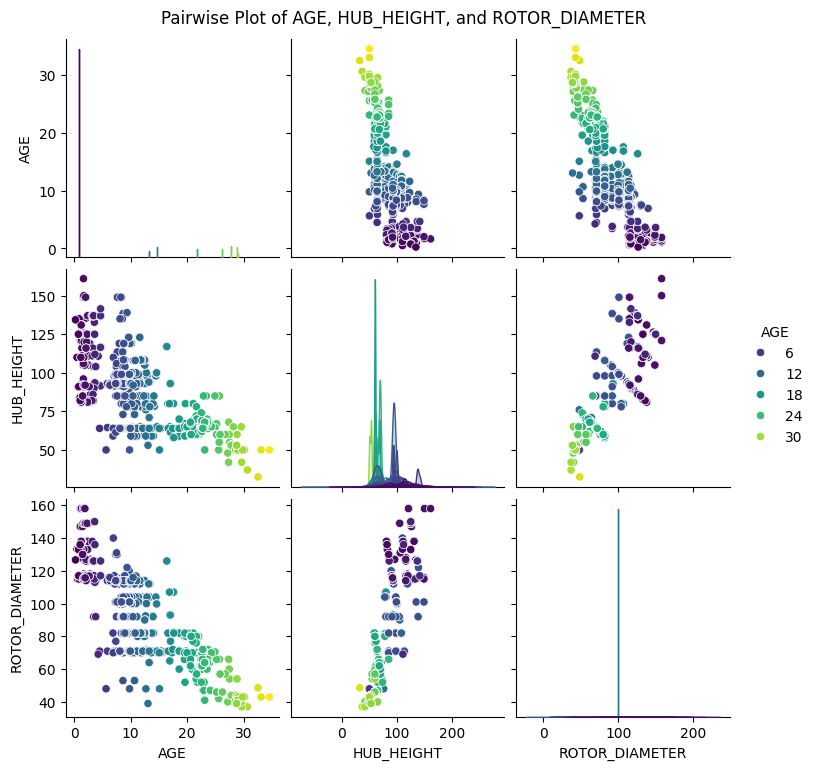

In [ ]:
# Pairwise plot
sns.pairplot(df, vars=['AGE', 'HUB_HEIGHT', 'ROTOR_DIAMETER'], kind='scatter', hue='AGE', palette='viridis')
plt.suptitle('Pairwise Plot of AGE, HUB_HEIGHT, and ROTOR_DIAMETER', y=1.02)
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkxnpz9sw/3oim_1yk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkxnpz9sw/mnvptw27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68502', 'data', 'file=/tmp/tmpkxnpz9sw/3oim_1yk.json', 'init=/tmp/tmpkxnpz9sw/mnvptw27.json', 'output', 'file=/tmp/tmpkxnpz9sw/prophet_modely6f9tfw8/prophet_model-20240810135334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:53:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds         yhat   yhat_lower    yhat_upper
2552 2029-05-08  5997.674244  1187.194530  10461.908822
2553 2029-05-09  5979.608538  1118.854667  10884.716702
2554 2029-05-10  5965.092685   973.801624  10753.296277
2555 2029-05-11  5954.095860  1406.354711  10297.210888
2556 2029-05-12  5946.481407  1373.882472  10564.000011


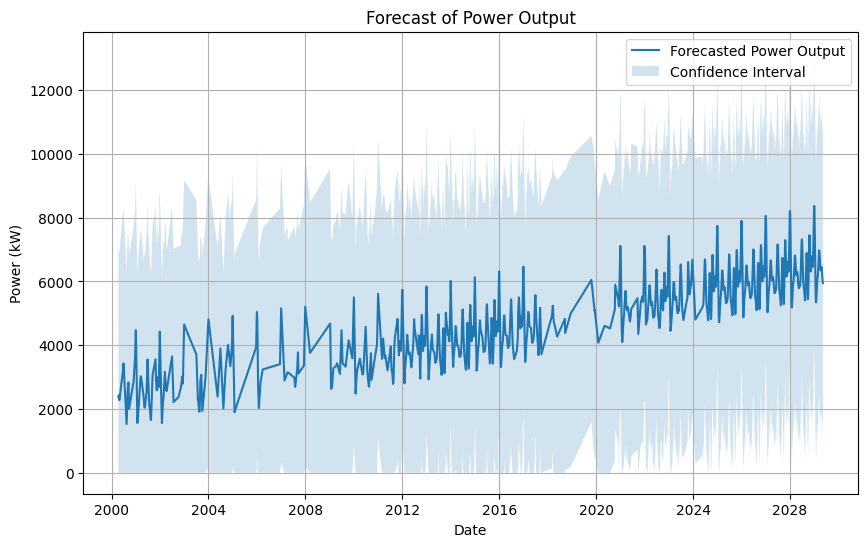

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

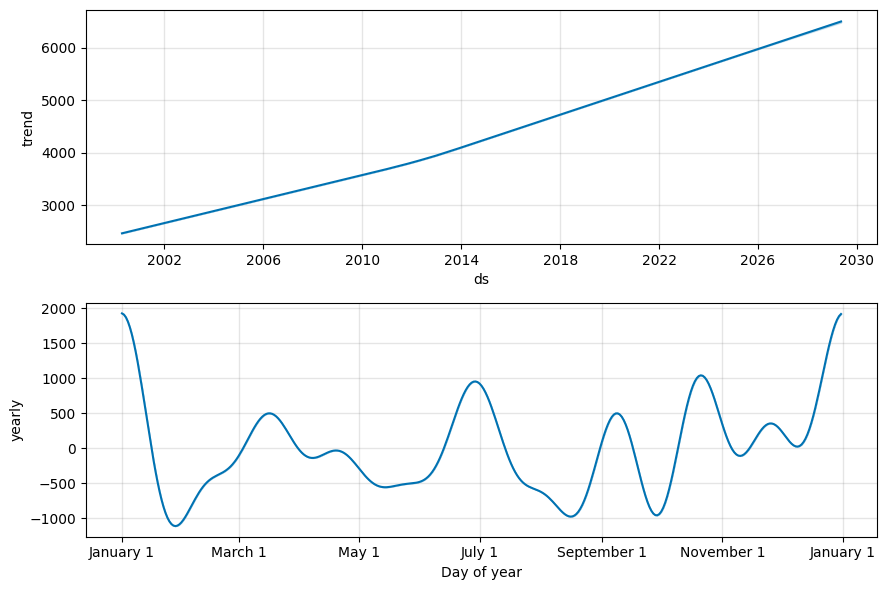

In [ ]:
# Filter the data to only include records from the year 2000 onwards
df = df[df['COMMISSIONED_ON'] >= '2000-01-01']

# Aggregate power output by commissioning date
df_prophet = df[['COMMISSIONED_ON', 'POWER']].dropna()
df_prophet = df_prophet.rename(columns={'COMMISSIONED_ON': 'ds', 'POWER': 'y'})
df_prophet = df_prophet.groupby('ds').sum().reset_index()

# Initialize the Prophet model without weekly seasonality
model = Prophet(weekly_seasonality=False)

# Fit the model to the data
model.fit(df_prophet)

# Create a dataframe with future dates
future = model.make_future_dataframe(periods=5 * 365)  # Forecasting 5 years into the future

# Make predictions
forecast = model.predict(future)

# Ensure power output is non-negative
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Display the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(forecast['ds'], forecast['yhat'], label='Forecasted Power Output')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, label='Confidence Interval')
ax.set_title('Forecast of Power Output')
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
ax.grid()
ax.legend()

# Show the plot
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)



